In [ ]:
#First trial of ML to find radial velocities. Goal is to use regression to extrapolate the velocities. 

In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

In [3]:
# These are just my choices to make the plots look nice
plt.rcParams.update({'font.family':'cmr10','font.size': 13})
matplotlib.rcParams['axes.unicode_minus']=False
matplotlib.rcParams['axes.labelsize']=15
plt.rcParams['figure.figsize']=(4,4)
plt.rcParams['figure.dpi'] = 80
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['mathtext.rm'] = 'serif'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

In [4]:
SimulatedStars = pd.read_csv('rave_tgas_cleaned_data.csv',index_col=None)

In [5]:
SimulatedStars.head()

,Unnamed: 0,ra,dec,b,l,logg,teff,gband,vr,vtheta,...,pmde_err,vU,vV,vW,vU_err,vV_err,vW_err,jband,kband,R_cyl
0,0,160.760542,-13.241389,39.009388,261.198041,4.02,6047.5,11.154045,-22.767779,-8.553811,...,1.109520,2.989305,-26.186428,0.468133,7.397238,2.740294,3.563465,10.313,9.981,8.059333
1,1,160.258125,-13.640972,38.394644,261.014525,1.92,4777.9,10.940921,-90.714933,13.228575,...,1.039390,59.797612,-69.816238,-28.596837,21.613296,8.263897,9.739697,9.513,8.868,8.191753
2,2,159.117958,-13.938889,37.476591,260.143047,3.76,5684.4,9.964015,17.192325,-17.679071,...,0.630677,-32.337603,-30.413529,10.738150,2.762826,0.893481,1.207606,9.107,8.738,8.030682
3,3,159.159667,-13.473472,37.865498,259.816167,3.75,5896.4,9.740564,-19.469996,-8.870117,...,0.576193,4.840963,-15.400051,1.330989,1.266904,0.713310,0.745443,8.843,8.585,8.024455
4,4,160.152417,-11.347833,40.129253,259.072345,2.50,4867.2,10.547413,3.542314,-11.618539,...,0.690997,-31.966993,-30.385995,4.604890,10.842726,1.868670,4.019525,9.129,8.482,8.166834


In [6]:
SimulatedStars.columns

Index(['Unnamed: 0', 'ra', 'dec', 'b', 'l', 'logg', 'teff', 'gband', 'vr',
       'vtheta', 'vphi', 'vr_err', 'vphi_err', 'vtheta_err', 'z', 'z_err',
       'distance', 'distance_err', 'R', 'feH', 'ID', 'hrv', 'hrv_err', 'pmra',
       'pmra_err', 'pmde', 'pmde_err', 'vU', 'vV', 'vW', 'vU_err', 'vV_err',
       'vW_err', 'jband', 'kband', 'R_cyl'],
      dtype='object')

In [7]:
SimulatedStars.shape

(164387, 36)

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [9]:
# What columns to use?
use_cols = ['l', 'b','distance','pmra','pmde']
# Make the design matrix
X = SimulatedStars[use_cols].values
Y = (SimulatedStars['vr']).values

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, Y,
                                                    test_size = 0.2,
                                                    random_state=42)

In [11]:
print(X_train.shape)
print(y_train.shape)
print('There are {0} stars in the training set'.format(np.sum(y_train)))
print()
print(X_test.shape)
print(y_test.shape)
print('There are {0} stars in the test set'.format(np.sum(y_test)))

(131509, 5)
(131509,)
There are 40356.09328778812 stars in the training set

(32878, 5)
(32878,)
There are 6386.546530267198 stars in the test set


In [12]:
# Might need to add in a data preprocessing step here 
#Either reweighting the radial velocity or training set features have 0 mean and unit variance

In [13]:
SS = StandardScaler()
X_train = SS.fit_transform(X_train)

In [14]:
# Now scale the test data using the same mean and standard deviation as found with the training data
X_test = SS.transform(X_test)

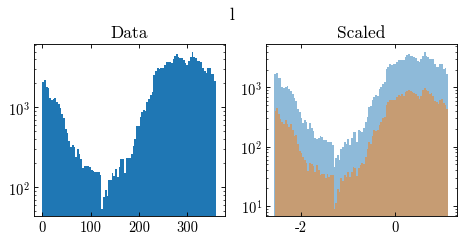

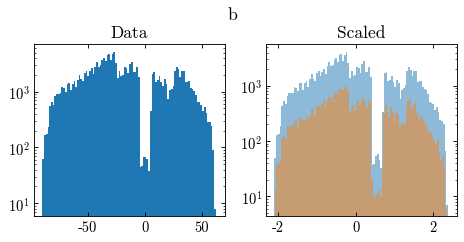

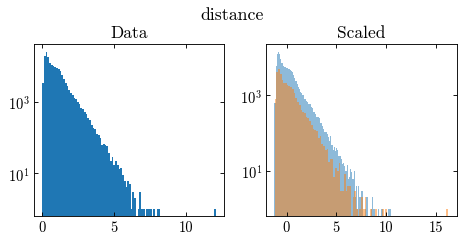

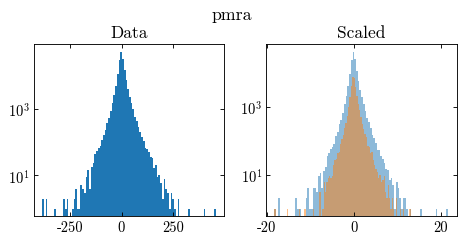

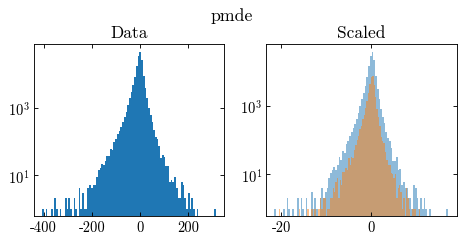

In [15]:
#visualize check data
for i, col in enumerate(use_cols):
    plt.figure(figsize=(6, 3))
    plt.subplot(1,2,1)
    plt.hist(SimulatedStars[col], bins=100)
    plt.yscale('log')
    plt.title('Data')
    
    plt.subplot(1,2,2)
    plt.hist(X_train[:, i], bins=100, alpha=0.5)
    plt.hist(X_test[:, i], bins=100, alpha=0.5)
    plt.yscale('log')
    plt.title('Scaled')
    
    plt.suptitle(col, y=1.01, fontsize=16)
    
    plt.tight_layout()

In [16]:
#Building Classifier 

In [17]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam

Using TensorFlow backend.


In [18]:
from keras import backend as K

In [19]:
def LikelihoodLossFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    SIGMA = K.abs(y_pred[:, 1])
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    
    ARG = K.square(X - LOC) / (2 * K.square(SIGMA))
    PREFACT = K.log(K.pow(2 * np.pi * K.square(SIGMA), -0.5))
    #you get this from the conditional probability distribution
    return K.mean(ARG - PREFACT)
    #return K.mean(ARG)
#now i'm wondering if somewhere in here I should return SIGMA

In [20]:
MyModel = Sequential()
MyModel.add(Dense(units=100, activation='relu', input_dim=X_train.shape[1]))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=100, activation='relu'))
MyModel.add(Dense(units=2))
#using tanh activation function in the last layer
#MyModel.compile(loss='mean_squared_error',
       #         optimizer='adam'
       #       )
MyModel.compile(loss=LikelihoodLossFunction,
                optimizer='adam'
               )

In [21]:
MyModel.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 2)                 202       
Total params: 21,002
Trainable params: 21,002
Non-trainable params: 0
_________________________________________________________________


In [22]:
#training any checkpoint or early stopping? 
es = EarlyStopping(patience=2, restore_best_weights=True)

In [23]:
print(y_train.shape[0])

131509


In [24]:
history = MyModel.fit(X_train,np.vstack([y_train,
                                  np.ones(y_train.shape[0])
                                  ]).T,
                      validation_split=0.2,
                      epochs=100,
                      batch_size=1000,
                      callbacks = [es]
                     )
#I think in adding the second column to the y_training values that is all 1s can give us an estimate of the error...

Train on 105207 samples, validate on 26302 samples
Epoch 1/100
105207/105207 [==============================] - 1s 7us/step - loss: 1052.4581 - val_loss: 52.3457
Epoch 2/100
105207/105207 [==============================] - 1s 5us/step - loss: 28.0676 - val_loss: 14.9667
Epoch 3/100
105207/105207 [==============================] - 1s 5us/step - loss: 10.6023 - val_loss: 7.5032
Epoch 4/100
105207/105207 [==============================] - 1s 5us/step - loss: 5.7660 - val_loss: 3.9214
Epoch 5/100
105207/105207 [==============================] - 1s 5us/step - loss: 2.9468 - val_loss: 2.2185
Epoch 6/100
105207/105207 [==============================] - 1s 5us/step - loss: 1.8496 - val_loss: 1.5316
Epoch 7/100
105207/105207 [==============================] - 1s 5us/step - loss: 1.3408 - val_loss: 1.1618
Epoch 8/100
105207/105207 [==============================] - 1s 5us/step - loss: 1.0455 - val_loss: 0.9308
Epoch 9/100
105207/105207 [==============================] - 1s 5us/step - loss: 0.852

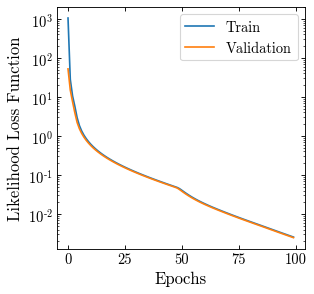

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.xlabel('Epochs')
plt.ylabel('Likelihood Loss Function')
plt.legend(['Train', 'Validation'])
plt.show()

In [26]:
# predict the scores for the test set, then histogram them based on the real labels
test_preds = MyModel.predict(X_test)
print(test_preds[1:100,1])

[ 649.2229   415.08966  389.6923   312.60074  586.36725  182.73174
  348.35098  572.6607   356.00607 1497.6156   807.0217   573.74866
  460.7266   750.2875  1030.2565   547.7125   272.6672  1533.1858
 1379.8685   356.0932   497.9498   771.6482   593.2471   611.5178
  586.5533  1142.2216   386.0159   792.6915  1737.9016   747.25464
  387.15567  315.57935  366.971   1266.7874  2291.346    451.2871
  289.87073  366.76462  385.86633 1944.2095  1067.7992   675.38007
  770.89197 1588.1265   828.36993  274.99045 1212.5416   345.13574
  526.442   1882.6654   373.0019   523.1532  1557.8467   874.38947
  540.2521  1760.3021  1360.5306   221.72852  312.28638  348.20987
 2754.0203   676.35803  372.20493  674.76715  437.12726 1928.7694
 1437.932    480.98038  395.437    761.4961   834.5377  1068.3759
 1101.2793   957.04395 1699.7738   680.0809  1362.4823  2245.0664
  493.3049   842.1377   259.7643   368.68832  674.84424  496.88998
 1073.386   1484.0433  1199.5767   168.08144  260.07297  198.73685
 

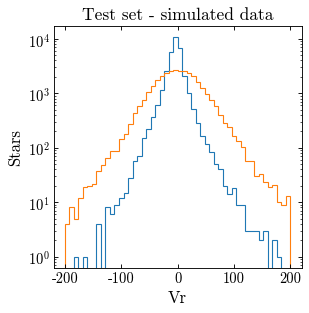

In [27]:
plt.hist(test_preds[:,0], bins=50, range=(-200,200), histtype='step')
plt.hist(y_test, bins=50, range=(-200,200), histtype='step')
plt.xlabel('Vr')
plt.ylabel('Stars')
plt.title('Test set - simulated data')
plt.yscale('log')
plt.show()


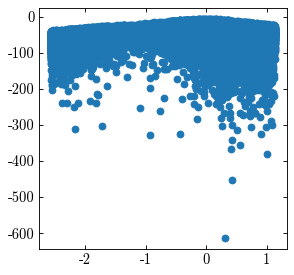

In [34]:
plt.scatter(X_test[:,0], test_preds[:,1])

Text(0, 0.5, 'Vr real')

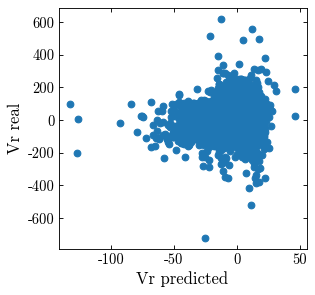

In [31]:
plt.scatter(test_preds[:,0],y_test)
plt.xlabel('Vr predicted')
plt.ylabel('Vr real')

In [5]:
def ConstantLikelihoodFunction(y_true, y_pred):
    # shape of y_pred should be (nsamples, 2)
    # the first column should be the mean of the prediction
    # the second column is the confidence (number of standard deviations)
#     print y_true.shape
#     print y_pred.shape
    LOC = y_pred[:, 0]
    X = y_true[:, 0]
    ARG = -K.square(X - LOC) / (2.0)
    return K.mean(-ARG)